In [215]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import re
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn import linear_model, neural_network
from sklearn.model_selection import train_test_split
from catboost import Pool, cv, CatBoostRegressor

sns.set(rc={'figure.figsize': (30,15)})

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/dataset.csv


In [216]:
import pandas as pd
df = pd.read_csv("../input/dataset.csv")

In [217]:
df.head(5)

,QuestionId,AnsweringTime,QuestionCreationDate,QuestionScore,QuestionViewCount,QuestionTags,QuestionAnswerCount,QuestionCommentCount,OwnerReputation,OwnerViews,OwnerUpVotes,OwnerDownVotes
0,6,14:14:42.9733333,2008-07-31 22:08:08,290,18687,<html><css><internet-explorer-7>,6,0,20928,5675,47,4
1,42,00:55:41.5100000,2008-08-01 12:50:18,267,35073,<php><plugins><architecture><hook>,8,0,7001,829,257,18
2,85,03:25:14.0033333,2008-08-01 14:19:52,116,54973,<php><sql><database><flat-file>,11,2,5637,274,24,4
3,337,00:25:38.9033333,2008-08-02 03:35:55,68,7878,<python><xml>,12,2,3308,404,663,3
4,709,00:05:27.4433333,2008-08-03 14:53:53,49,5988,<c#><.net><visual-studio><unit-testing>,10,1,3308,404,663,3


In [218]:
df.shape

(50000, 12)

In [219]:
df['AnsweringTimeTransformed'] = df['AnsweringTime'].apply(lambda x : x.split('.')[0])
df.head()

,QuestionId,AnsweringTime,QuestionCreationDate,QuestionScore,QuestionViewCount,QuestionTags,QuestionAnswerCount,QuestionCommentCount,OwnerReputation,OwnerViews,OwnerUpVotes,OwnerDownVotes,AnsweringTimeTransformed
0,6,14:14:42.9733333,2008-07-31 22:08:08,290,18687,<html><css><internet-explorer-7>,6,0,20928,5675,47,4,14:14:42
1,42,00:55:41.5100000,2008-08-01 12:50:18,267,35073,<php><plugins><architecture><hook>,8,0,7001,829,257,18,00:55:41
2,85,03:25:14.0033333,2008-08-01 14:19:52,116,54973,<php><sql><database><flat-file>,11,2,5637,274,24,4,03:25:14
3,337,00:25:38.9033333,2008-08-02 03:35:55,68,7878,<python><xml>,12,2,3308,404,663,3,00:25:38
4,709,00:05:27.4433333,2008-08-03 14:53:53,49,5988,<c#><.net><visual-studio><unit-testing>,10,1,3308,404,663,3,00:05:27


In [220]:
df['AnsweringTimeDT'] = pd.to_datetime(df['AnsweringTimeTransformed'],format= '%H:%M:%S' ).dt.time

df['AnsweringTimeHours'] = pd.to_datetime(df['AnsweringTimeTransformed'],format= '%H:%M:%S' ).dt.hour

df['AnsweringTimeMinutes'] = pd.to_datetime(df['AnsweringTimeTransformed'],format= '%H:%M:%S' ).dt.minute
df['AnsweringTimeInMinutes'] = df['AnsweringTimeHours'] * 60 + df['AnsweringTimeMinutes']

df['AnsweringTimeSeconds'] = pd.to_datetime(df['AnsweringTimeTransformed'],format= '%H:%M:%S' ).dt.second
df['AnsweringTimeInSeconds'] = df['AnsweringTimeHours'] * 60 * 60 + df['AnsweringTimeMinutes'] * 60 + df['AnsweringTimeSeconds']


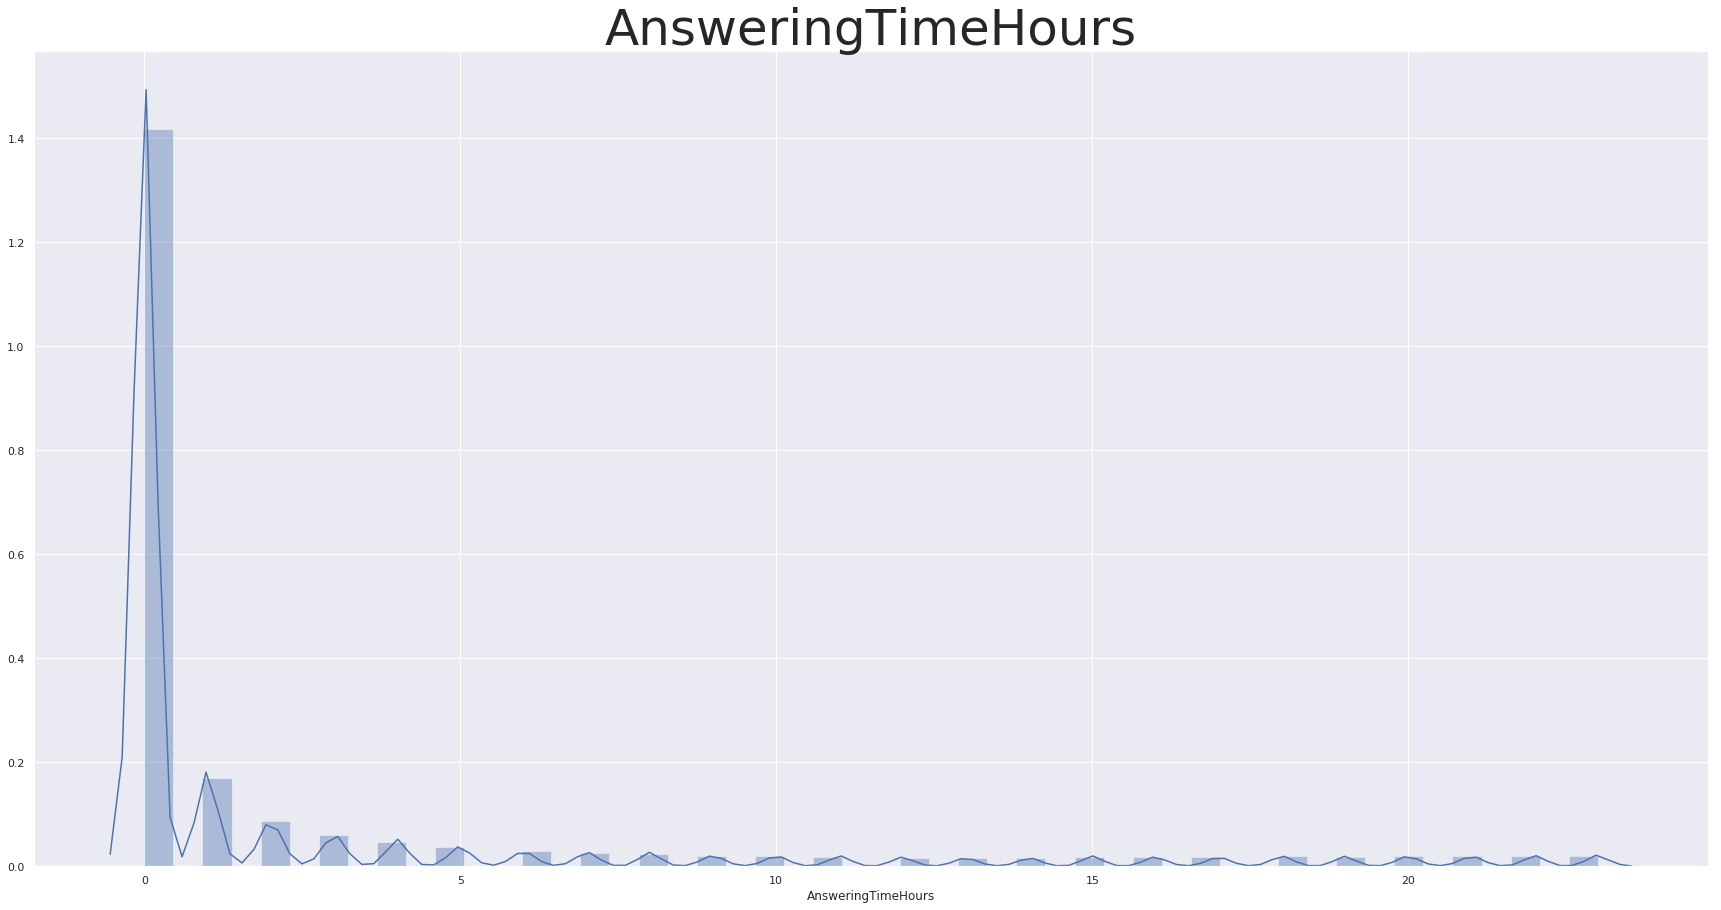

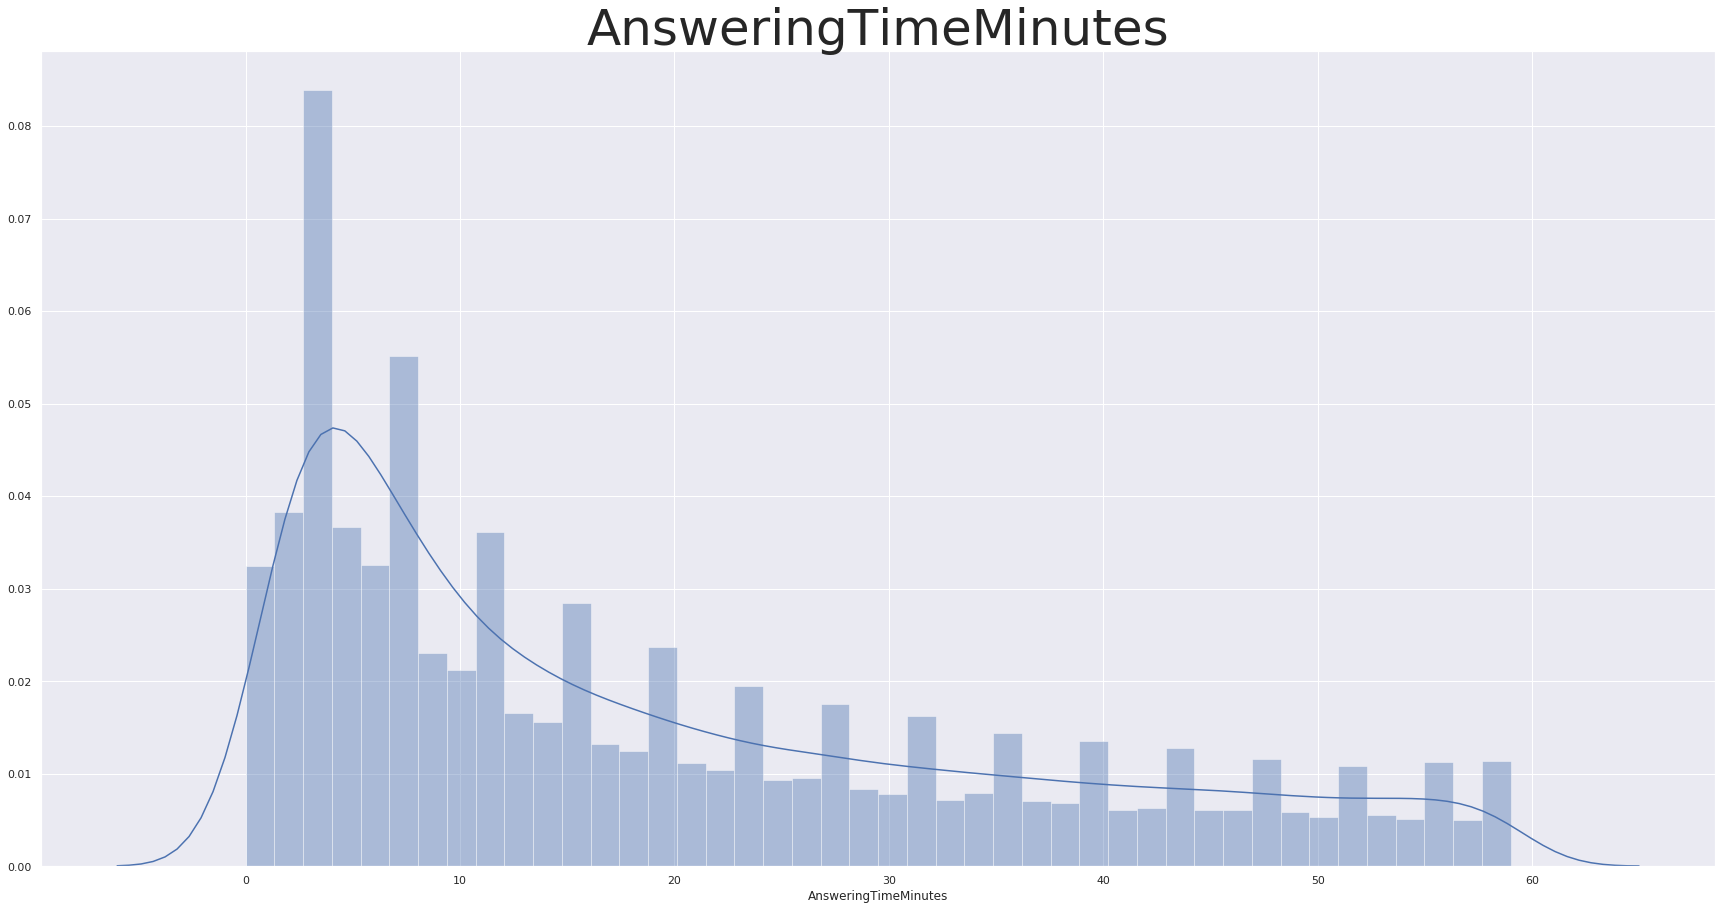

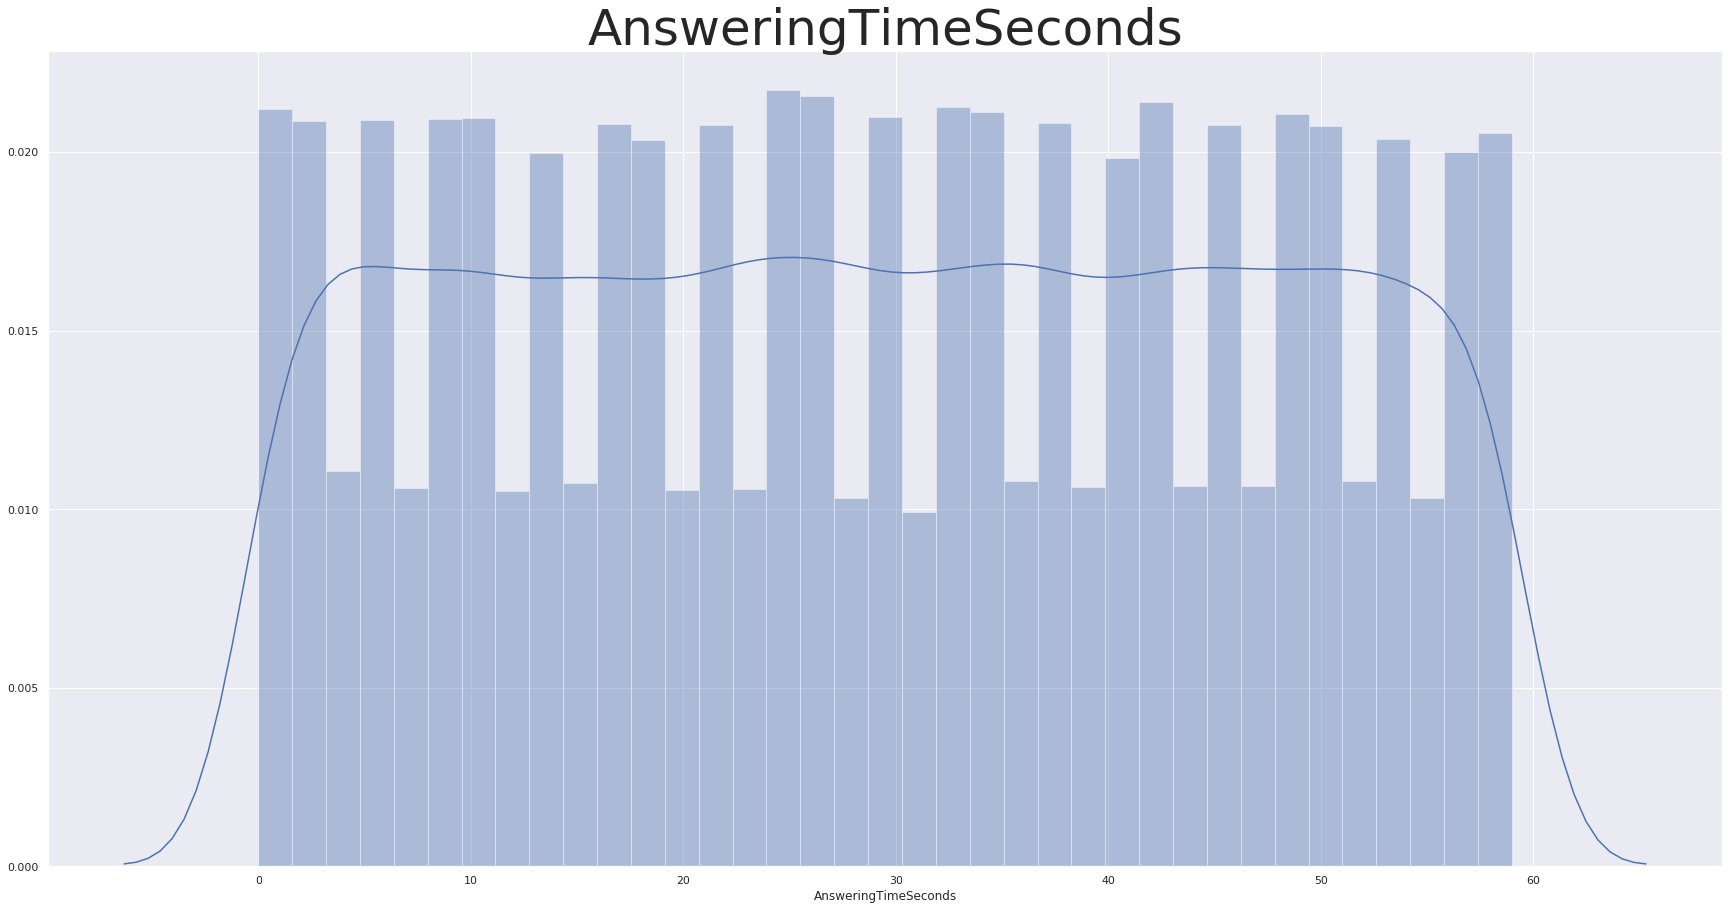

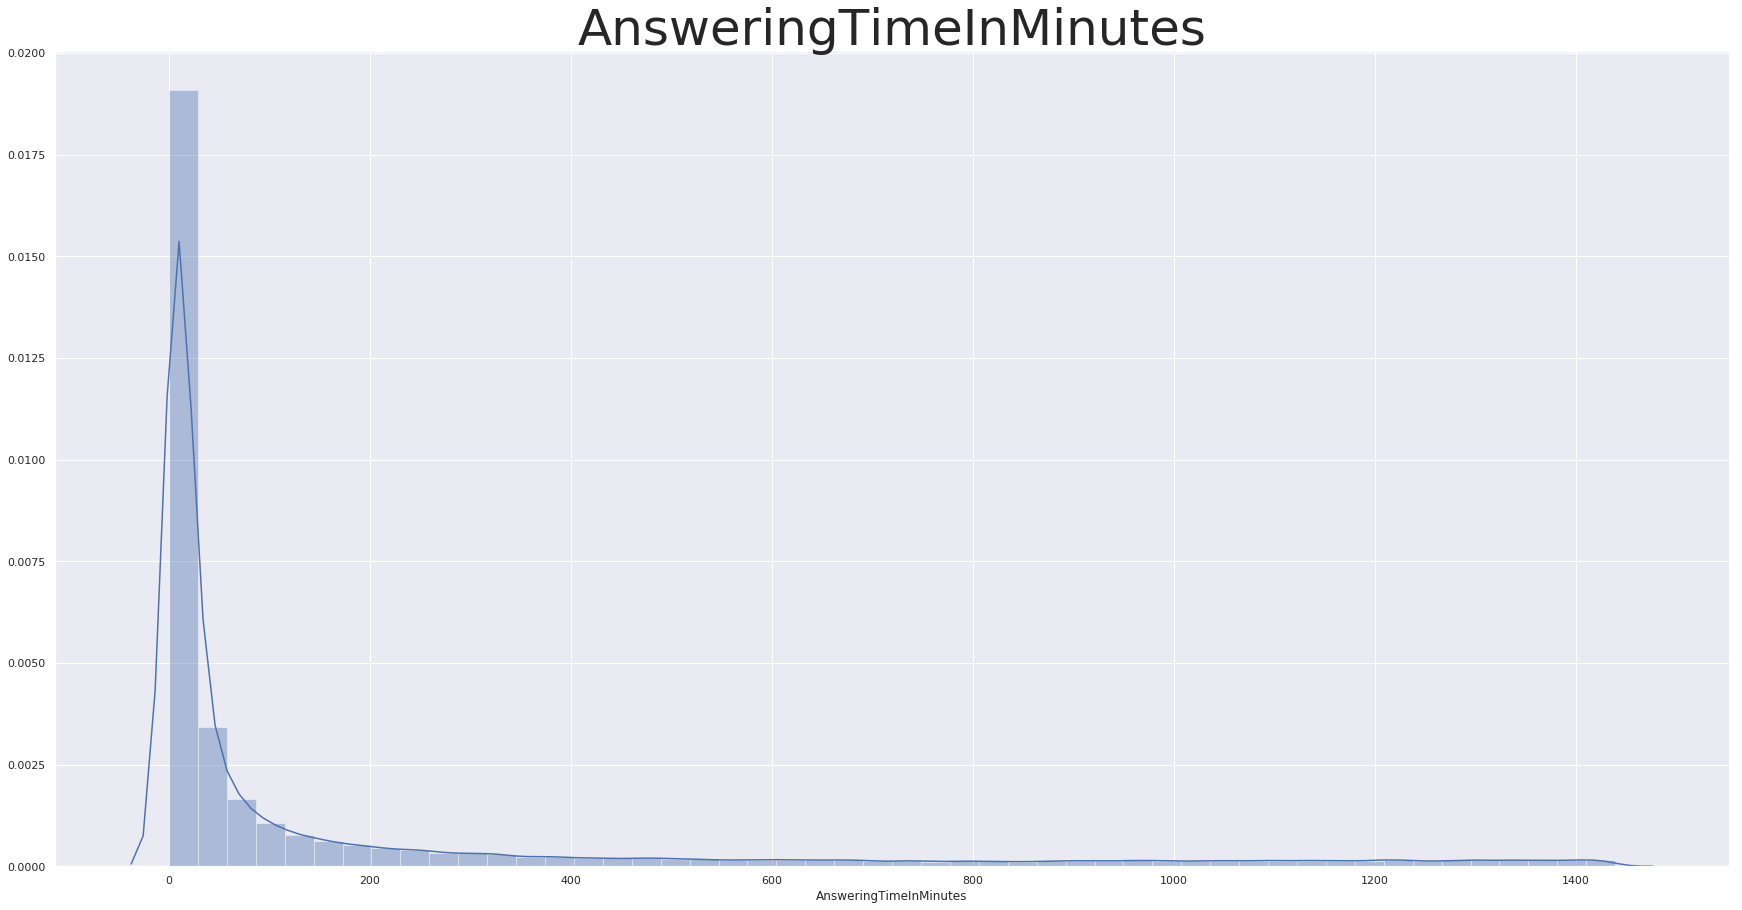

Text(0.5, 1.0, 'AnsweringTimeInSeconds')

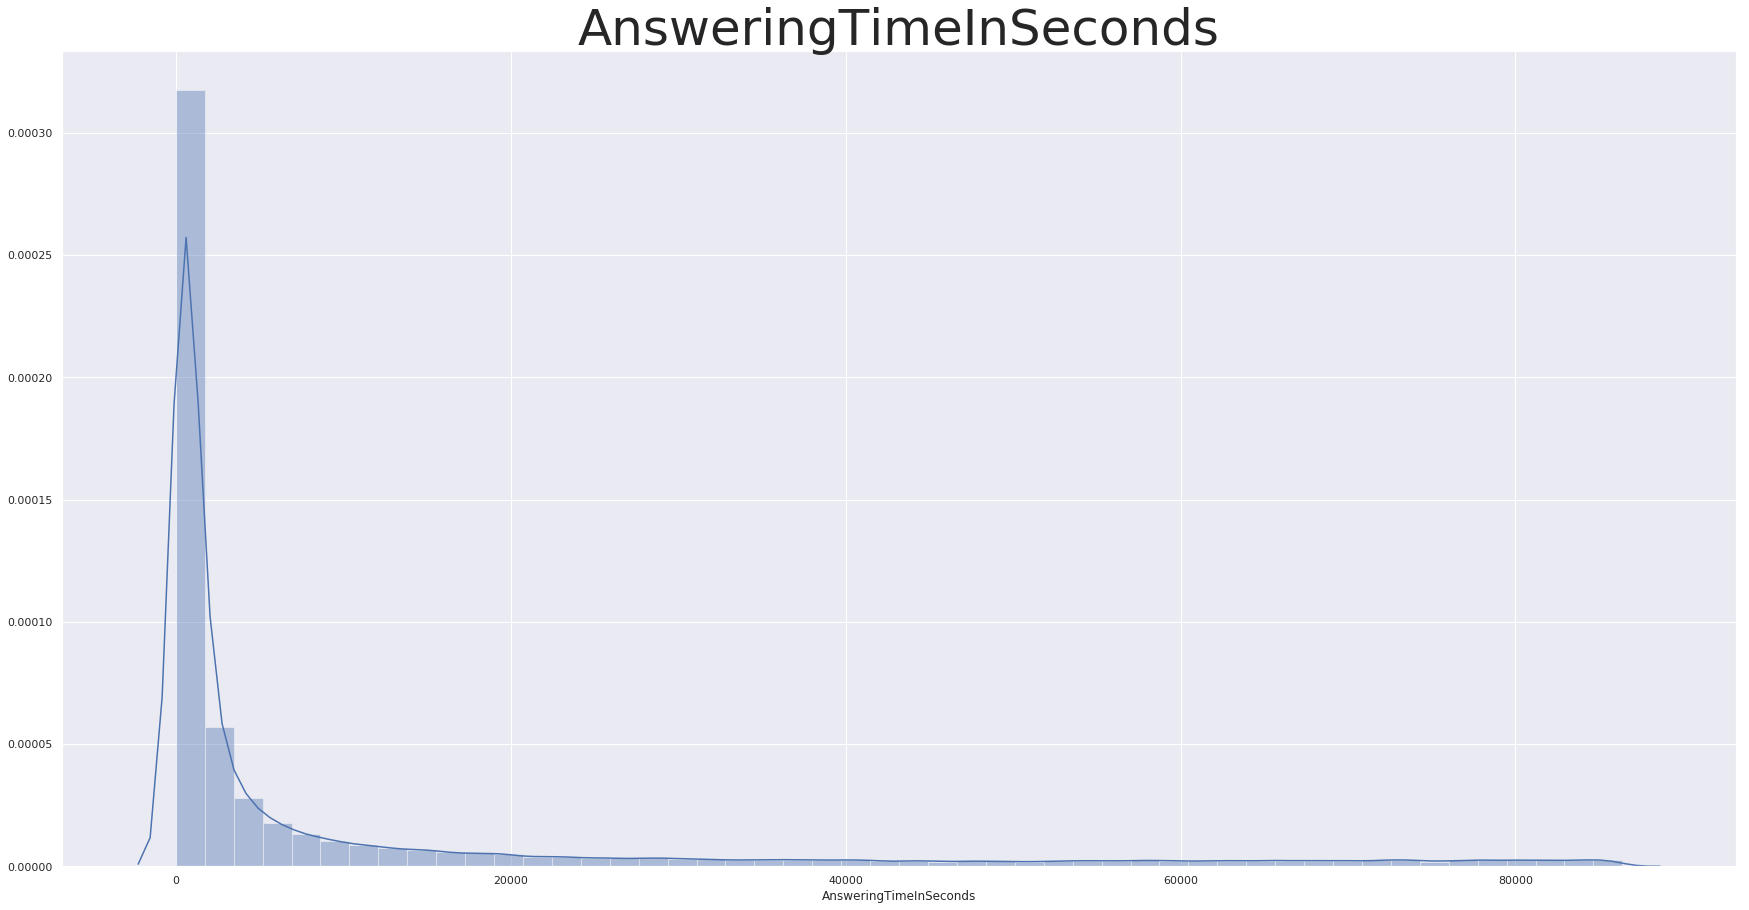

In [221]:
ax = sns.distplot(df.AnsweringTimeHours)
ax.set_title("AnsweringTimeHours",fontsize=50)
plt.show()

ax = sns.distplot(df.AnsweringTimeMinutes)
ax.set_title("AnsweringTimeMinutes",fontsize=50)
plt.show()

ax = sns.distplot(df.AnsweringTimeSeconds)
ax.set_title("AnsweringTimeSeconds",fontsize=50)
plt.show()

ax = sns.distplot(df.AnsweringTimeInMinutes)
ax.set_title("AnsweringTimeInMinutes",fontsize=50)
plt.show()

ax = sns.distplot(df.AnsweringTimeInSeconds)
ax.set_title("AnsweringTimeInSeconds",fontsize=50)


In [222]:
df['TagList'] = df.QuestionTags.apply(lambda s : list(filter(lambda x : x not in ['','<','>'], re.split("(<|>)", s))))

In [223]:
merged = []
for l in df.TagList.values:
    merged += l

In [224]:
from collections import Counter

tag_counts = Counter(merged)
tag_df = pd.DataFrame.from_dict(tag_counts, columns=['cnt'], orient='index')

In [225]:
print(tag_df.sort_values(by=['cnt'], ascending=False).index[:20])
print("NUMBER OF UNIQUE TAGS:")
print(tag_df.shape)
tag_df.sort_values(by=['cnt'], ascending=False).head(100)

Index(['c#', 'java', '.net', 'asp.net', 'php', 'javascript', 'c++', 'jquery',
       'sql', 'python', 'iphone', 'sql-server', 'html', 'mysql', 'asp.net-mvc',
       'wpf', 'c', 'ruby-on-rails', 'css', 'objective-c'],
      dtype='object')
NUMBER OF UNIQUE TAGS:
(9409, 1)


,cnt
c#,7164
java,3677
.net,3600
asp.net,2999
php,2965
...,...
optimization,201
shell,195
templates,192
email,191


In [226]:
def tag_top_N_cover_perc(df, N):
    print(N)
    lst = list(tag_df.sort_values(by=['cnt'], ascending=False).head(N).index)
    return df[df.TagList.apply(lambda l : len([x for x in l if x in lst]) != 0)].shape[0]

In [227]:
TOTAL = df.shape[0]

cover_percs = [ tag_top_N_cover_perc(df, i) * 1.0 / TOTAL for i in range(1,1000)]

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64


KeyboardInterrupt: 

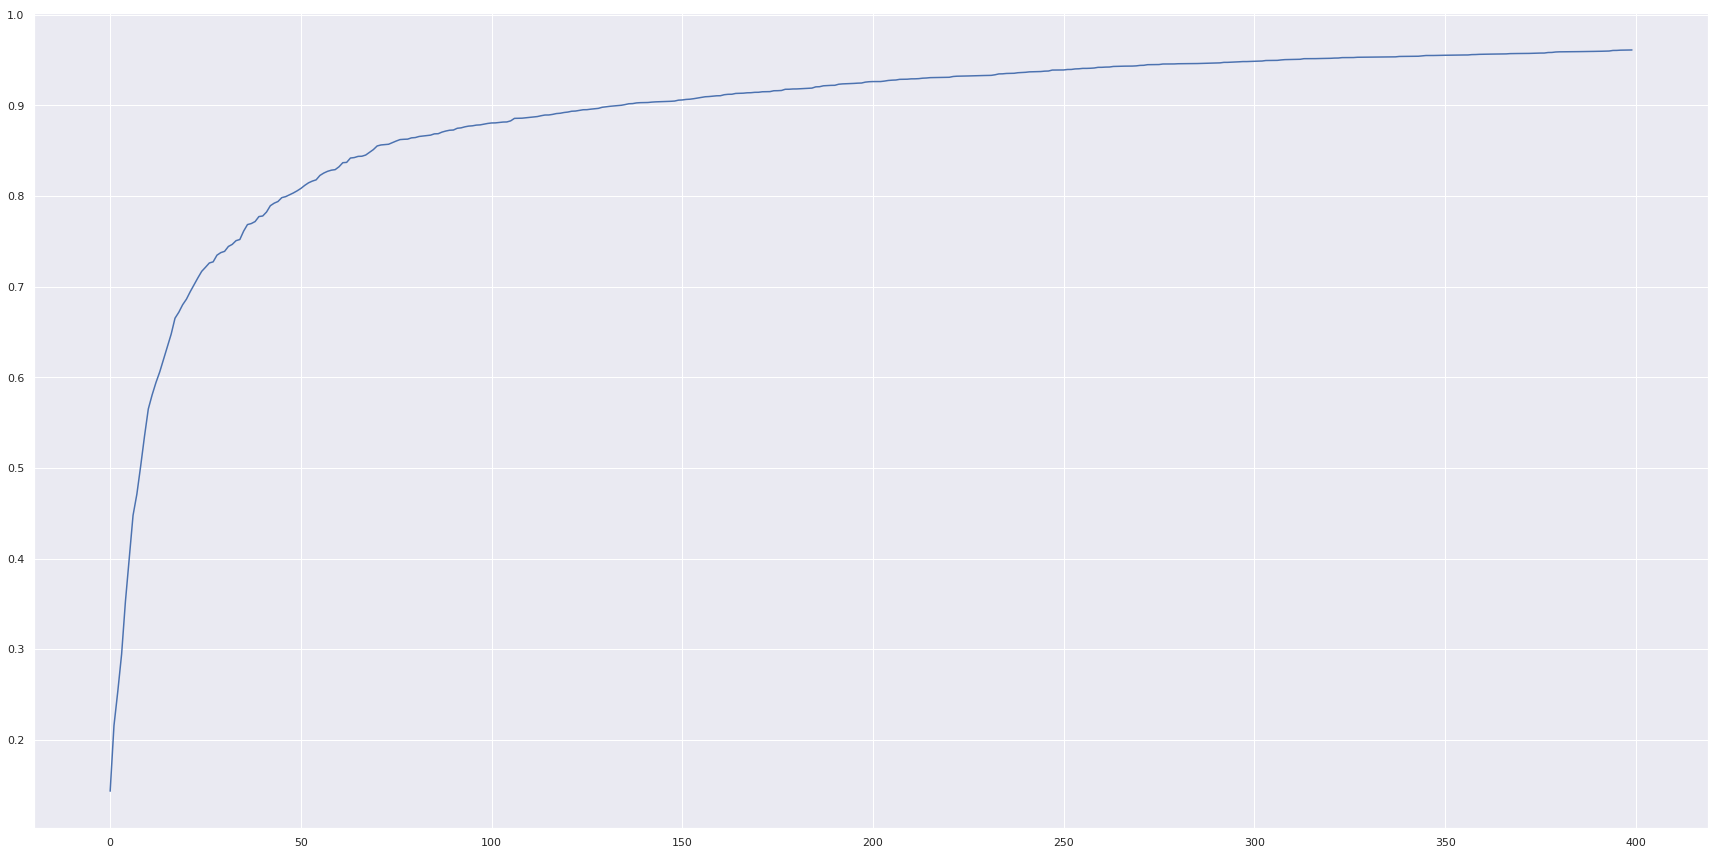

In [228]:
sample = cover_percs[:400]
plt.plot(list(range(len(sample))), sample)

## Let's only use the most 150 used tags

In [229]:
TAGS_TO_USE = list(tag_df.sort_values(by=['cnt'], ascending=False).head(150).index)

## Let's use as the target variable the number of minutes in which the question on Stack Overflow was answered

## MEAN PREDICTION

In [230]:
PREDICTED_RESPONSE = [df.AnsweringTimeInMinutes.mean()] * df.shape[0]

print("MSE:")
print(mean_squared_error(df.AnsweringTimeInMinutes.values, PREDICTED_RESPONSE))
print("MAE:")
print(mean_absolute_error(df.AnsweringTimeInMinutes.values, PREDICTED_RESPONSE))


MSE:
114390.94385388639
MAE:
234.6399601008


## OTHER TYPES OF PREDICTION

### Let's see the correlation between the target variable and oher variables

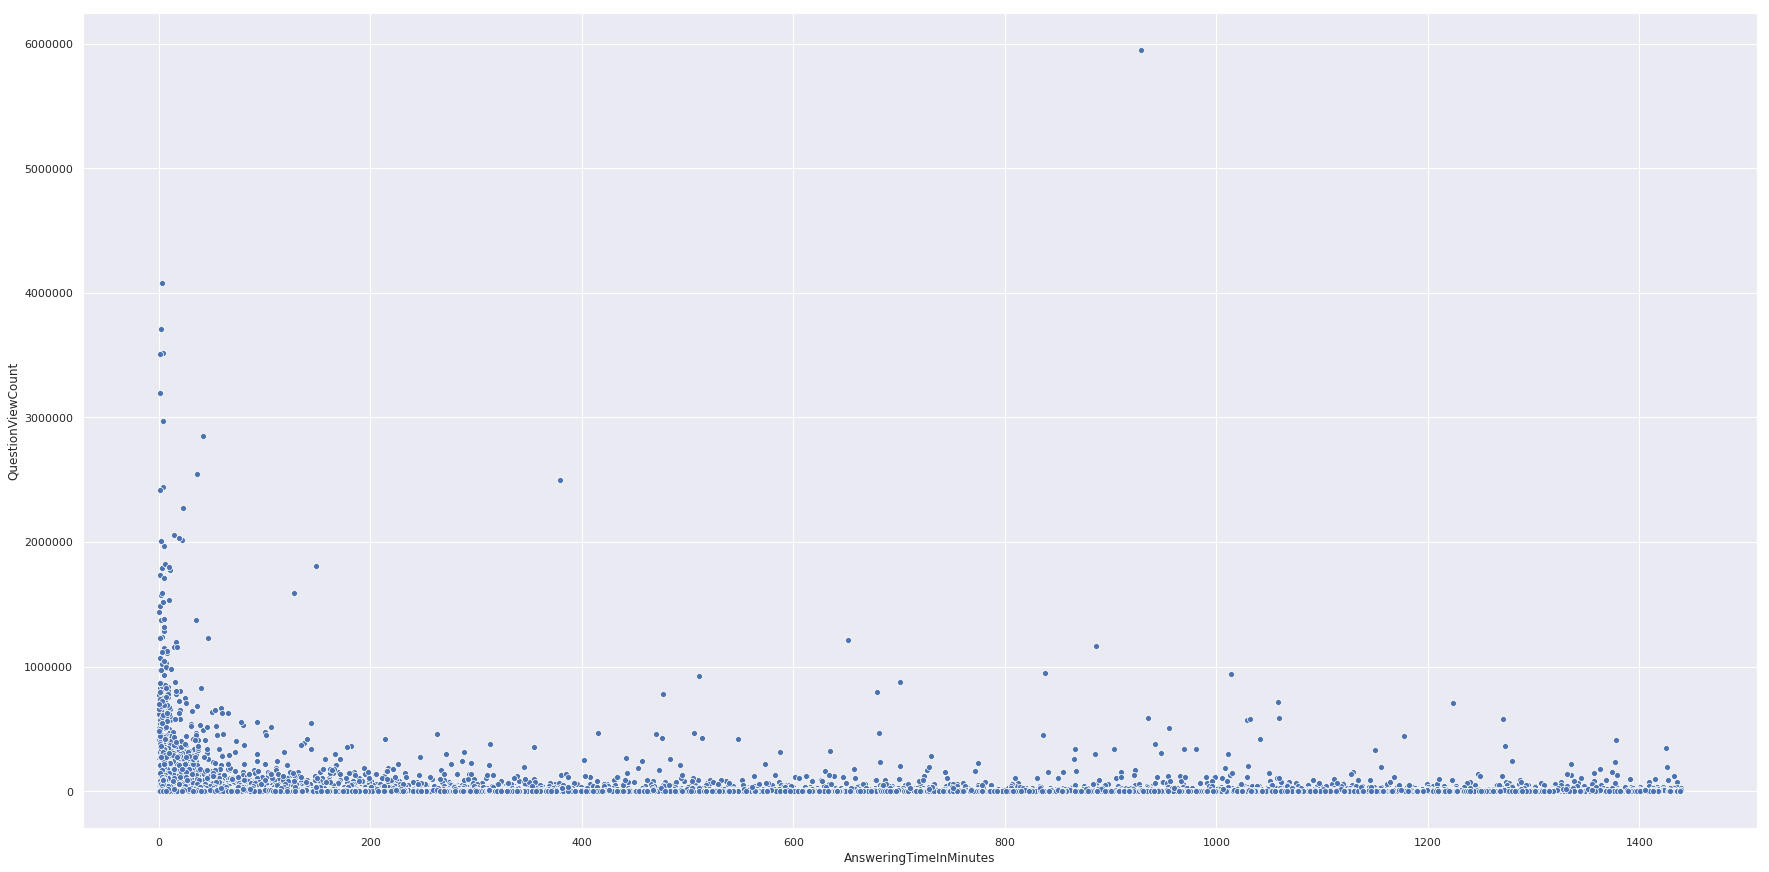

In [231]:
sns.scatterplot(x='AnsweringTimeInMinutes',y='QuestionViewCount',data=df)

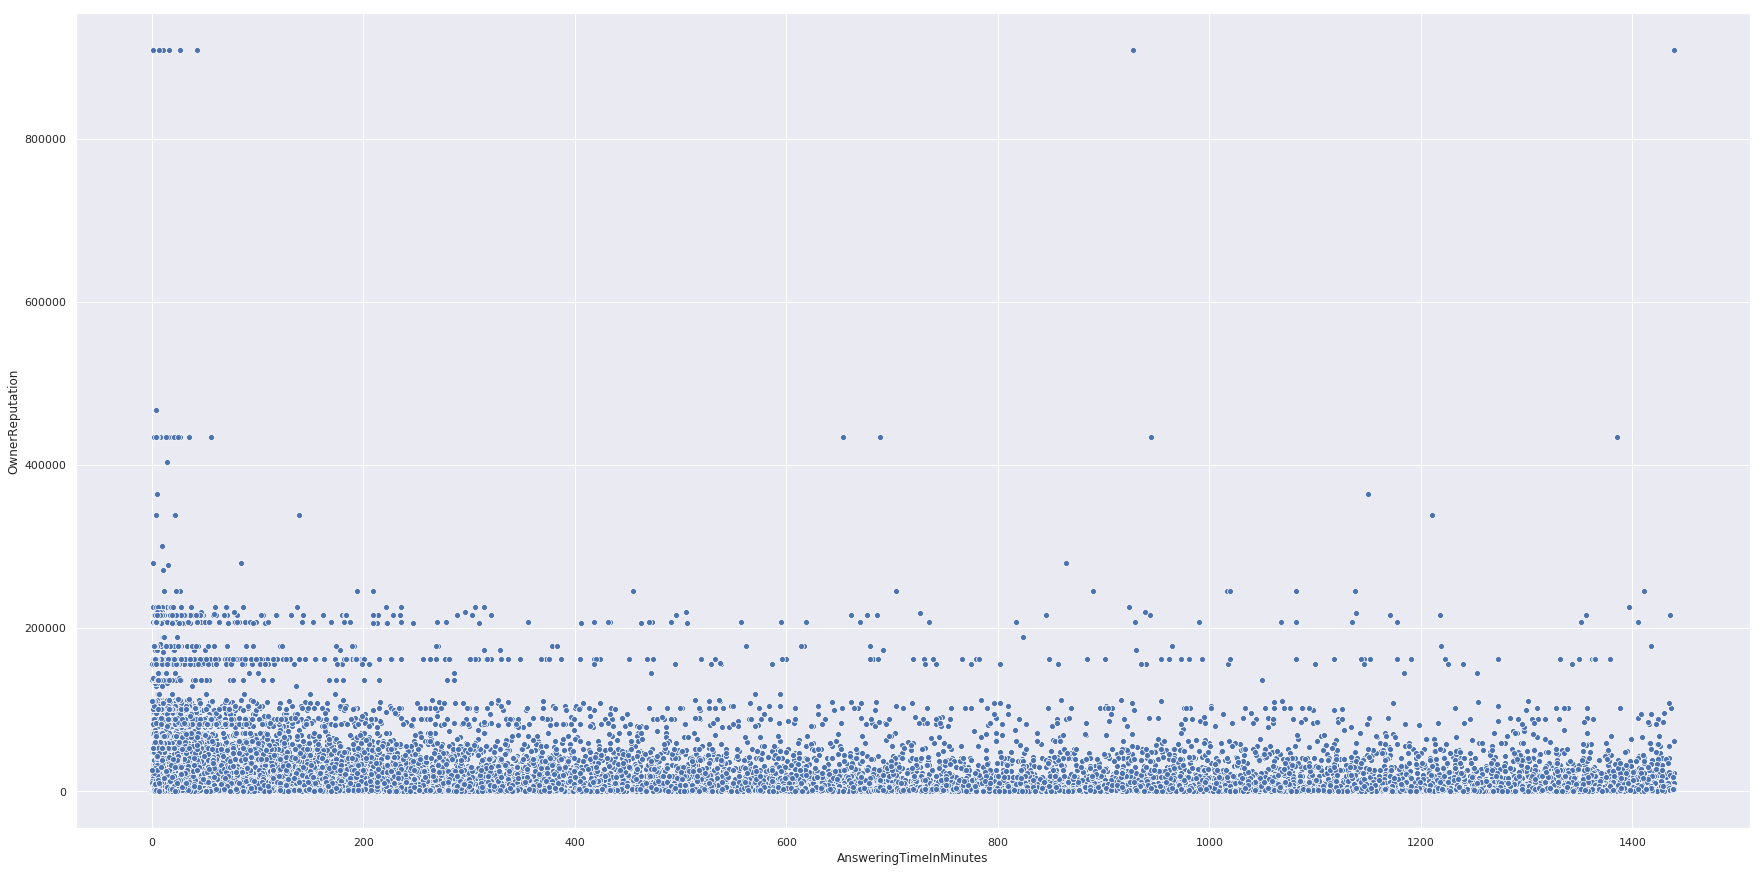

In [232]:
sns.scatterplot(x='AnsweringTimeInMinutes',y='OwnerReputation',data=df)

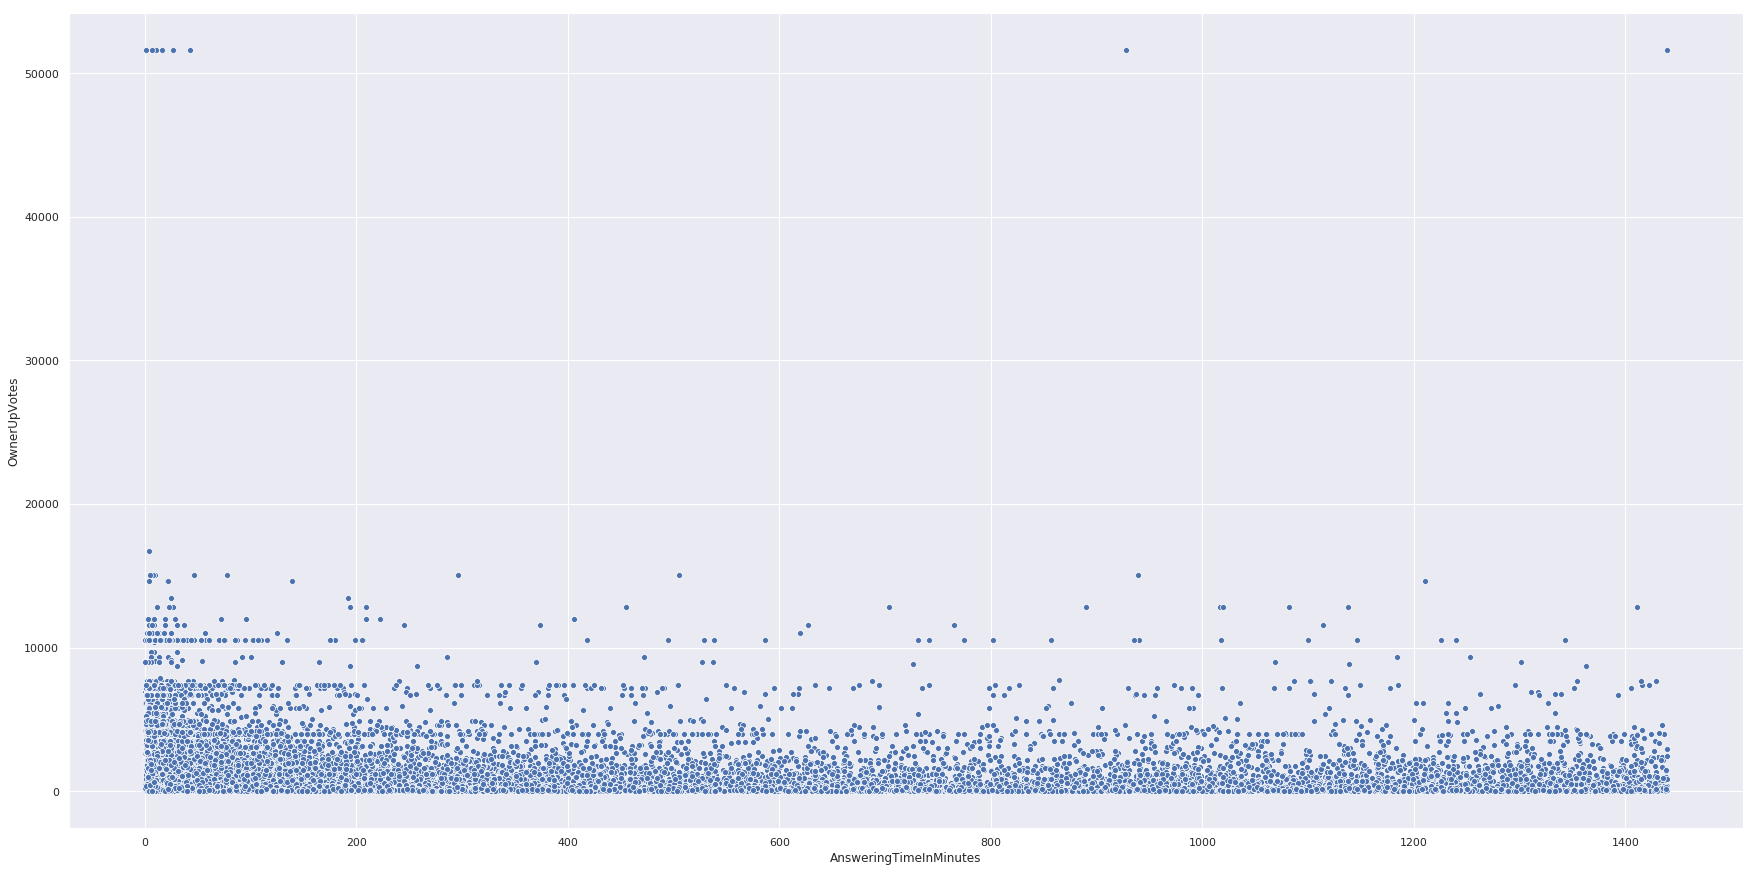

In [233]:
sns.scatterplot(x='AnsweringTimeInMinutes',y='OwnerUpVotes',data=df)

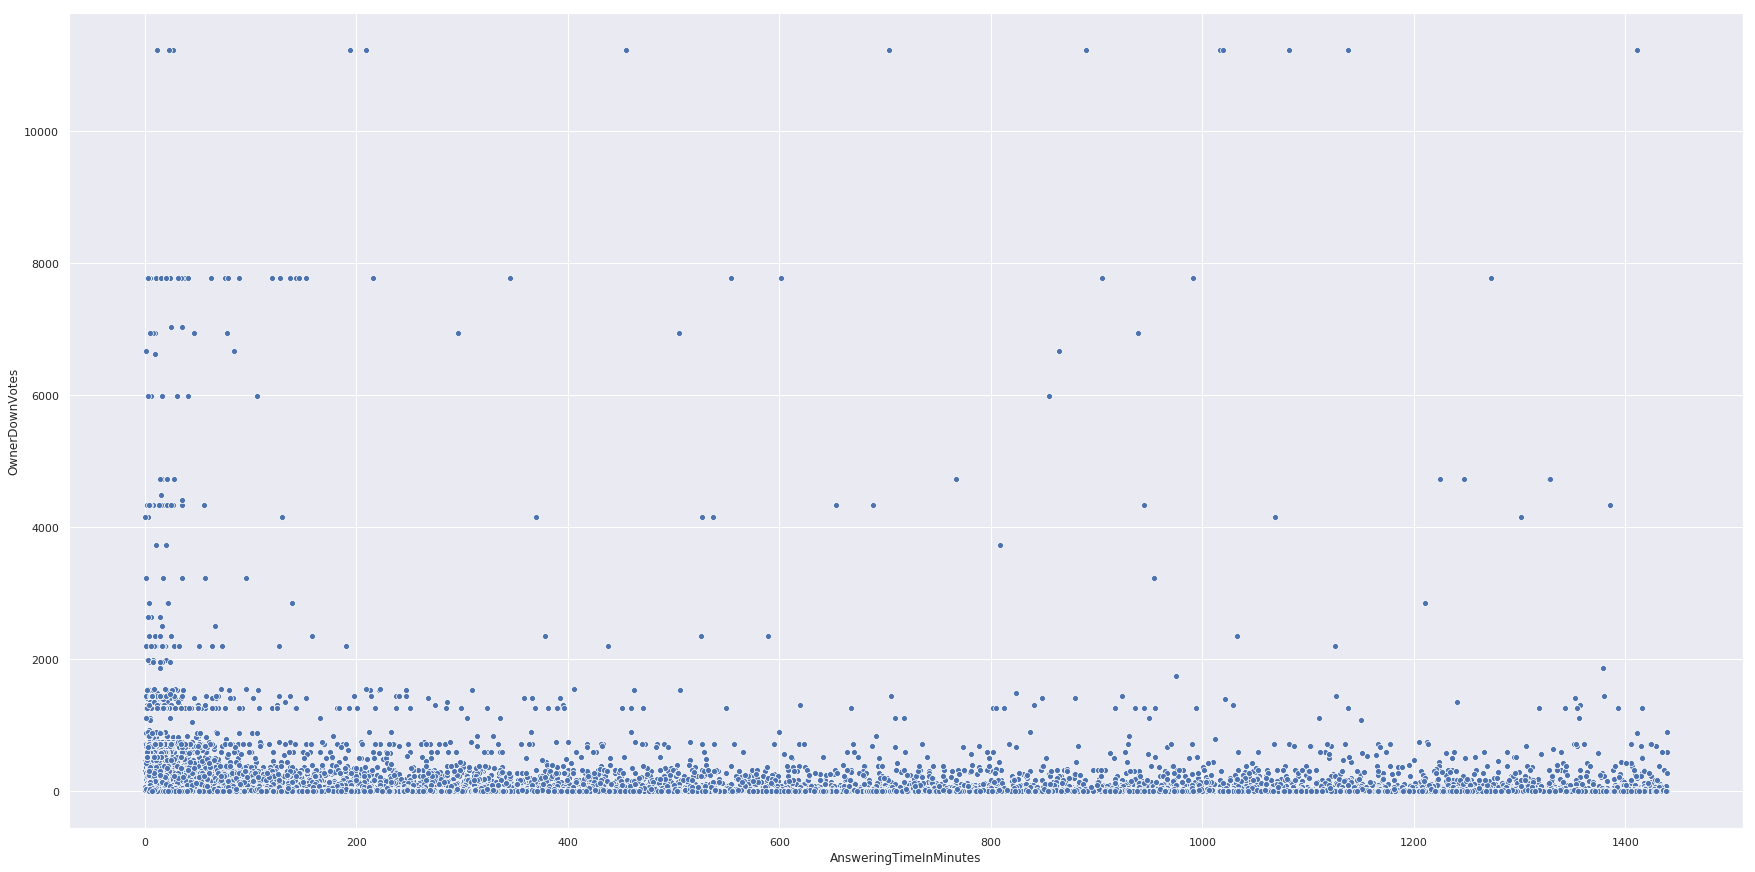

In [234]:
sns.scatterplot(x='AnsweringTimeInMinutes',y='OwnerDownVotes',data=df)

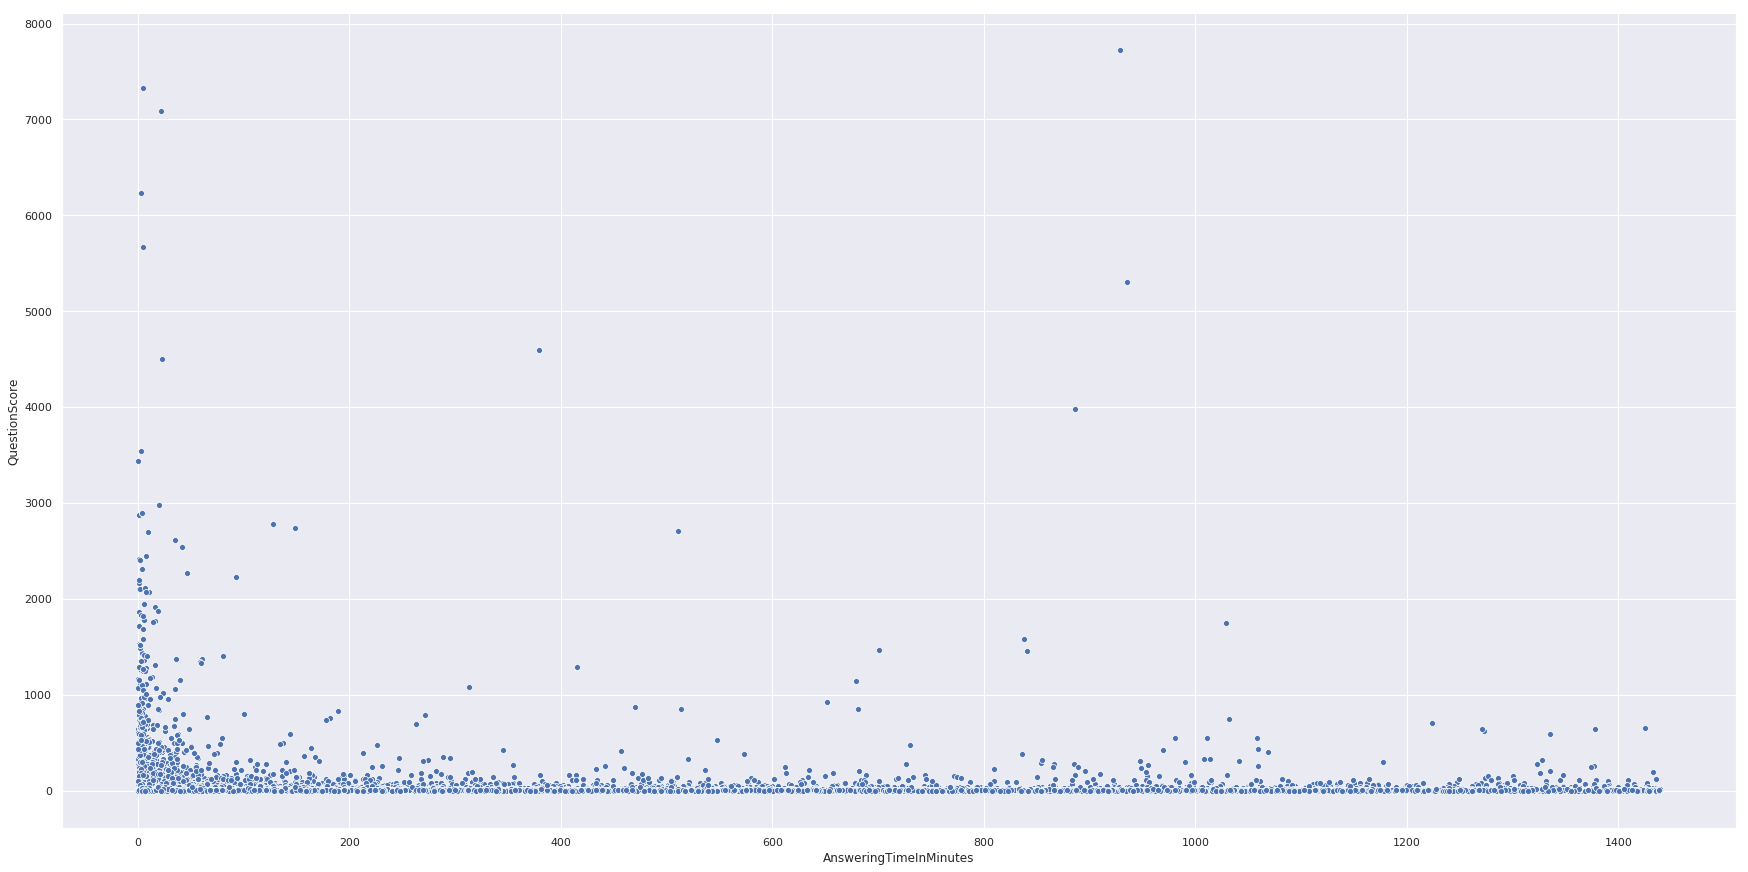

In [235]:
sns.scatterplot(x='AnsweringTimeInMinutes',y='QuestionScore',data=df)

## CONCLUSION: No clear correlation at this point.

## Let's experiment with some other models

In [236]:
edf = df.copy()

In [237]:
def filter_list(l, tags_to_use):
    return [elem for elem in l if elem in tags_to_use]

In [238]:
edf.TagList = edf.TagList.apply(lambda x : filter_list(x, TAGS_TO_USE))

In [239]:
edf.head()

,QuestionId,AnsweringTime,QuestionCreationDate,QuestionScore,QuestionViewCount,QuestionTags,QuestionAnswerCount,QuestionCommentCount,OwnerReputation,OwnerViews,OwnerUpVotes,OwnerDownVotes,AnsweringTimeTransformed,AnsweringTimeDT,AnsweringTimeHours,AnsweringTimeMinutes,AnsweringTimeInMinutes,AnsweringTimeSeconds,AnsweringTimeInSeconds,TagList
0,6,14:14:42.9733333,2008-07-31 22:08:08,290,18687,<html><css><internet-explorer-7>,6,0,20928,5675,47,4,14:14:42,14:14:42,14,14,854,42,51282,"[html, css]"
1,42,00:55:41.5100000,2008-08-01 12:50:18,267,35073,<php><plugins><architecture><hook>,8,0,7001,829,257,18,00:55:41,00:55:41,0,55,55,41,3341,"[php, architecture]"
2,85,03:25:14.0033333,2008-08-01 14:19:52,116,54973,<php><sql><database><flat-file>,11,2,5637,274,24,4,03:25:14,03:25:14,3,25,205,14,12314,"[php, sql, database]"
3,337,00:25:38.9033333,2008-08-02 03:35:55,68,7878,<python><xml>,12,2,3308,404,663,3,00:25:38,00:25:38,0,25,25,38,1538,"[python, xml]"
4,709,00:05:27.4433333,2008-08-03 14:53:53,49,5988,<c#><.net><visual-studio><unit-testing>,10,1,3308,404,663,3,00:05:27,00:05:27,0,5,5,27,327,"[c#, .net, visual-studio, unit-testing]"


In [240]:
mlb = MultiLabelBinarizer()
df2 = edf.join(pd.DataFrame(mlb.fit_transform(edf.pop('TagList')), columns=mlb.classes_, index=edf.index))

In [241]:
print(list(df2.columns))

['QuestionId', 'AnsweringTime', 'QuestionCreationDate', 'QuestionScore', 'QuestionViewCount', 'QuestionTags', 'QuestionAnswerCount', 'QuestionCommentCount', 'OwnerReputation', 'OwnerViews', 'OwnerUpVotes', 'OwnerDownVotes', 'AnsweringTimeTransformed', 'AnsweringTimeDT', 'AnsweringTimeHours', 'AnsweringTimeMinutes', 'AnsweringTimeInMinutes', 'AnsweringTimeSeconds', 'AnsweringTimeInSeconds', '.net', '.net-3.5', 'actionscript-3', 'ajax', 'algorithm', 'android', 'apache', 'apache-flex', 'api', 'architecture', 'arrays', 'asp.net', 'asp.net-mvc', 'authentication', 'bash', 'c', 'c#', 'c++', 'caching', 'class', 'cocoa', 'cocoa-touch', 'coding-style', 'collections', 'com', 'configuration', 'css', 'data-binding', 'database', 'database-design', 'date', 'datetime', 'debugging', 'delphi', 'deployment', 'design-patterns', 'django', 'dll', 'dom', 'eclipse', 'email', 'entity-framework', 'events', 'excel', 'exception', 'file', 'firefox', 'flash', 'forms', 'function', 'generics', 'git', 'google-app-engi

In [242]:
df2.drop([
    'QuestionId', 
    'AnsweringTime', 
    'QuestionCreationDate', 
    'QuestionTags', 
    'AnsweringTimeTransformed', 
    'AnsweringTimeDT', 
    'AnsweringTimeHours',
    'AnsweringTimeMinutes',
    'AnsweringTimeSeconds',
    'AnsweringTimeInSeconds',
],axis=1,inplace=True)

In [243]:
target = 'AnsweringTimeInMinutes'
cat_features = TAGS_TO_USE
X = df2.drop([target],axis=1)
y = df2[target]

In [244]:
xtrain,xtest,ytrain,ytest = train_test_split(X,y,train_size=.8,random_state=1236)

In [245]:
model = CatBoostRegressor(
    iterations=3000, 
    learning_rate=0.01, 
    l2_leaf_reg=3.5, 
    depth=8, 
    rsm=0.98, 
    loss_function= 'RMSE', 
    eval_metric='RMSE',
    random_seed=42
)

In [246]:
model.fit(xtrain,ytrain,cat_features=cat_features)


0:	learn: 338.0242552	total: 27.6ms	remaining: 1m 22s
1:	learn: 337.9614881	total: 48.9ms	remaining: 1m 13s
2:	learn: 337.8922385	total: 68.8ms	remaining: 1m 8s
3:	learn: 337.8364637	total: 87.9ms	remaining: 1m 5s
4:	learn: 337.7793283	total: 107ms	remaining: 1m 3s
5:	learn: 337.7235839	total: 125ms	remaining: 1m 2s
6:	learn: 337.6670073	total: 143ms	remaining: 1m 1s
7:	learn: 337.6151030	total: 161ms	remaining: 1m
8:	learn: 337.5587211	total: 179ms	remaining: 59.6s
9:	learn: 337.4982272	total: 197ms	remaining: 59s
10:	learn: 337.4439428	total: 215ms	remaining: 58.5s
11:	learn: 337.3845830	total: 235ms	remaining: 58.6s
12:	learn: 337.3377101	total: 254ms	remaining: 58.3s
13:	learn: 337.2872394	total: 272ms	remaining: 58s
14:	learn: 337.2344992	total: 291ms	remaining: 58s
15:	learn: 337.1886754	total: 310ms	remaining: 57.8s
16:	learn: 337.1316163	total: 330ms	remaining: 57.8s
17:	learn: 337.0788745	total: 348ms	remaining: 57.6s
18:	learn: 337.0335041	total: 366ms	remaining: 57.4s
19:	le

158:	learn: 333.2526308	total: 2.92s	remaining: 52.3s
159:	learn: 333.2346652	total: 2.94s	remaining: 52.3s
160:	learn: 333.2154421	total: 2.96s	remaining: 52.3s
161:	learn: 333.1980297	total: 2.98s	remaining: 52.3s
162:	learn: 333.1857276	total: 3s	remaining: 52.3s
163:	learn: 333.1673262	total: 3.02s	remaining: 52.3s
164:	learn: 333.1481129	total: 3.05s	remaining: 52.4s
165:	learn: 333.1316422	total: 3.07s	remaining: 52.4s
166:	learn: 333.1124409	total: 3.09s	remaining: 52.4s
167:	learn: 333.0973495	total: 3.1s	remaining: 52.3s
168:	learn: 333.0820166	total: 3.12s	remaining: 52.3s
169:	learn: 333.0632269	total: 3.14s	remaining: 52.3s
170:	learn: 333.0501356	total: 3.16s	remaining: 52.3s
171:	learn: 333.0315883	total: 3.18s	remaining: 52.2s
172:	learn: 333.0143829	total: 3.19s	remaining: 52.2s
173:	learn: 333.0011727	total: 3.21s	remaining: 52.2s
174:	learn: 332.9796238	total: 3.23s	remaining: 52.1s
175:	learn: 332.9629196	total: 3.25s	remaining: 52.1s
176:	learn: 332.9482294	total: 3

315:	learn: 331.2186660	total: 5.81s	remaining: 49.3s
316:	learn: 331.2081287	total: 5.83s	remaining: 49.3s
317:	learn: 331.1941594	total: 5.85s	remaining: 49.3s
318:	learn: 331.1854214	total: 5.87s	remaining: 49.3s
319:	learn: 331.1780014	total: 5.88s	remaining: 49.3s
320:	learn: 331.1694206	total: 5.9s	remaining: 49.3s
321:	learn: 331.1632880	total: 5.92s	remaining: 49.3s
322:	learn: 331.1524431	total: 5.94s	remaining: 49.2s
323:	learn: 331.1445515	total: 5.96s	remaining: 49.2s
324:	learn: 331.1325370	total: 5.98s	remaining: 49.2s
325:	learn: 331.1226451	total: 6s	remaining: 49.2s
326:	learn: 331.1139887	total: 6.02s	remaining: 49.2s
327:	learn: 331.1065898	total: 6.04s	remaining: 49.2s
328:	learn: 331.0986934	total: 6.06s	remaining: 49.2s
329:	learn: 331.0850128	total: 6.08s	remaining: 49.2s
330:	learn: 331.0743941	total: 6.1s	remaining: 49.2s
331:	learn: 331.0630362	total: 6.12s	remaining: 49.2s
332:	learn: 331.0518010	total: 6.14s	remaining: 49.2s
333:	learn: 331.0414214	total: 6.

470:	learn: 329.8270672	total: 8.7s	remaining: 46.7s
471:	learn: 329.8209736	total: 8.72s	remaining: 46.7s
472:	learn: 329.8143899	total: 8.74s	remaining: 46.7s
473:	learn: 329.8029558	total: 8.75s	remaining: 46.7s
474:	learn: 329.7913852	total: 8.77s	remaining: 46.6s
475:	learn: 329.7763642	total: 8.79s	remaining: 46.6s
476:	learn: 329.7699862	total: 8.81s	remaining: 46.6s
477:	learn: 329.7610340	total: 8.83s	remaining: 46.6s
478:	learn: 329.7544114	total: 8.85s	remaining: 46.6s
479:	learn: 329.7473878	total: 8.87s	remaining: 46.5s
480:	learn: 329.7358350	total: 8.88s	remaining: 46.5s
481:	learn: 329.7275513	total: 8.91s	remaining: 46.5s
482:	learn: 329.7201734	total: 8.93s	remaining: 46.5s
483:	learn: 329.7151941	total: 8.94s	remaining: 46.5s
484:	learn: 329.7075600	total: 8.96s	remaining: 46.5s
485:	learn: 329.7018686	total: 8.98s	remaining: 46.4s
486:	learn: 329.6952766	total: 8.99s	remaining: 46.4s
487:	learn: 329.6867743	total: 9.01s	remaining: 46.4s
488:	learn: 329.6735677	total

627:	learn: 328.6824557	total: 11.6s	remaining: 43.8s
628:	learn: 328.6715830	total: 11.6s	remaining: 43.8s
629:	learn: 328.6633292	total: 11.6s	remaining: 43.8s
630:	learn: 328.6565043	total: 11.7s	remaining: 43.7s
631:	learn: 328.6444543	total: 11.7s	remaining: 43.7s
632:	learn: 328.6363931	total: 11.7s	remaining: 43.7s
633:	learn: 328.6320250	total: 11.7s	remaining: 43.7s
634:	learn: 328.6275232	total: 11.7s	remaining: 43.7s
635:	learn: 328.6214471	total: 11.7s	remaining: 43.6s
636:	learn: 328.6154021	total: 11.8s	remaining: 43.6s
637:	learn: 328.6096284	total: 11.8s	remaining: 43.6s
638:	learn: 328.6016913	total: 11.8s	remaining: 43.6s
639:	learn: 328.5923699	total: 11.8s	remaining: 43.6s
640:	learn: 328.5864086	total: 11.8s	remaining: 43.6s
641:	learn: 328.5736800	total: 11.9s	remaining: 43.6s
642:	learn: 328.5654434	total: 11.9s	remaining: 43.5s
643:	learn: 328.5608837	total: 11.9s	remaining: 43.5s
644:	learn: 328.5546658	total: 11.9s	remaining: 43.5s
645:	learn: 328.5511998	tota

782:	learn: 327.6999523	total: 14.5s	remaining: 41s
783:	learn: 327.6964802	total: 14.5s	remaining: 41s
784:	learn: 327.6901607	total: 14.5s	remaining: 41s
785:	learn: 327.6855154	total: 14.5s	remaining: 40.9s
786:	learn: 327.6788072	total: 14.6s	remaining: 40.9s
787:	learn: 327.6729470	total: 14.6s	remaining: 40.9s
788:	learn: 327.6656154	total: 14.6s	remaining: 40.9s
789:	learn: 327.6591097	total: 14.6s	remaining: 40.9s
790:	learn: 327.6545724	total: 14.6s	remaining: 40.9s
791:	learn: 327.6501707	total: 14.6s	remaining: 40.8s
792:	learn: 327.6465501	total: 14.7s	remaining: 40.8s
793:	learn: 327.6398707	total: 14.7s	remaining: 40.8s
794:	learn: 327.6316971	total: 14.7s	remaining: 40.8s
795:	learn: 327.6213199	total: 14.7s	remaining: 40.8s
796:	learn: 327.6170154	total: 14.7s	remaining: 40.8s
797:	learn: 327.6135415	total: 14.8s	remaining: 40.7s
798:	learn: 327.6039620	total: 14.8s	remaining: 40.7s
799:	learn: 327.5967741	total: 14.8s	remaining: 40.7s
800:	learn: 327.5915897	total: 14.

938:	learn: 326.7261273	total: 17.4s	remaining: 38.2s
939:	learn: 326.7202685	total: 17.4s	remaining: 38.1s
940:	learn: 326.7147300	total: 17.4s	remaining: 38.1s
941:	learn: 326.7107312	total: 17.4s	remaining: 38.1s
942:	learn: 326.7067310	total: 17.5s	remaining: 38.1s
943:	learn: 326.7013992	total: 17.5s	remaining: 38.1s
944:	learn: 326.6959800	total: 17.5s	remaining: 38s
945:	learn: 326.6895918	total: 17.5s	remaining: 38s
946:	learn: 326.6852216	total: 17.5s	remaining: 38s
947:	learn: 326.6803422	total: 17.5s	remaining: 38s
948:	learn: 326.6793509	total: 17.6s	remaining: 37.9s
949:	learn: 326.6696780	total: 17.6s	remaining: 37.9s
950:	learn: 326.6643746	total: 17.6s	remaining: 37.9s
951:	learn: 326.6609043	total: 17.6s	remaining: 37.9s
952:	learn: 326.6575802	total: 17.6s	remaining: 37.9s
953:	learn: 326.6487482	total: 17.7s	remaining: 37.9s
954:	learn: 326.6396999	total: 17.7s	remaining: 37.8s
955:	learn: 326.6292289	total: 17.7s	remaining: 37.8s
956:	learn: 326.6256006	total: 17.7s

1092:	learn: 325.6485121	total: 20.3s	remaining: 35.4s
1093:	learn: 325.6398271	total: 20.3s	remaining: 35.4s
1094:	learn: 325.6298437	total: 20.3s	remaining: 35.4s
1095:	learn: 325.6230377	total: 20.4s	remaining: 35.4s
1096:	learn: 325.6192734	total: 20.4s	remaining: 35.4s
1097:	learn: 325.6154115	total: 20.4s	remaining: 35.3s
1098:	learn: 325.6044599	total: 20.4s	remaining: 35.3s
1099:	learn: 325.5970941	total: 20.4s	remaining: 35.3s
1100:	learn: 325.5865781	total: 20.5s	remaining: 35.3s
1101:	learn: 325.5790865	total: 20.5s	remaining: 35.3s
1102:	learn: 325.5749965	total: 20.5s	remaining: 35.2s
1103:	learn: 325.5638836	total: 20.5s	remaining: 35.2s
1104:	learn: 325.5580762	total: 20.5s	remaining: 35.2s
1105:	learn: 325.5540247	total: 20.6s	remaining: 35.2s
1106:	learn: 325.5494185	total: 20.6s	remaining: 35.2s
1107:	learn: 325.5410768	total: 20.6s	remaining: 35.2s
1108:	learn: 325.5365304	total: 20.6s	remaining: 35.1s
1109:	learn: 325.5316516	total: 20.6s	remaining: 35.1s
1110:	lear

1253:	learn: 324.2925985	total: 23.4s	remaining: 32.6s
1254:	learn: 324.2840521	total: 23.4s	remaining: 32.6s
1255:	learn: 324.2765875	total: 23.5s	remaining: 32.6s
1256:	learn: 324.2706675	total: 23.5s	remaining: 32.5s
1257:	learn: 324.2653645	total: 23.5s	remaining: 32.5s
1258:	learn: 324.2613332	total: 23.5s	remaining: 32.5s
1259:	learn: 324.2483049	total: 23.5s	remaining: 32.5s
1260:	learn: 324.2393526	total: 23.5s	remaining: 32.5s
1261:	learn: 324.2324834	total: 23.6s	remaining: 32.5s
1262:	learn: 324.2223638	total: 23.6s	remaining: 32.4s
1263:	learn: 324.2159318	total: 23.6s	remaining: 32.4s
1264:	learn: 324.2046879	total: 23.6s	remaining: 32.4s
1265:	learn: 324.1929919	total: 23.6s	remaining: 32.4s
1266:	learn: 324.1821574	total: 23.7s	remaining: 32.4s
1267:	learn: 324.1729242	total: 23.7s	remaining: 32.3s
1268:	learn: 324.1624568	total: 23.7s	remaining: 32.3s
1269:	learn: 324.1581244	total: 23.7s	remaining: 32.3s
1270:	learn: 324.1530215	total: 23.7s	remaining: 32.3s
1271:	lear

1405:	learn: 322.9588243	total: 26.3s	remaining: 29.9s
1406:	learn: 322.9540551	total: 26.3s	remaining: 29.8s
1407:	learn: 322.9424044	total: 26.4s	remaining: 29.8s
1408:	learn: 322.9347212	total: 26.4s	remaining: 29.8s
1409:	learn: 322.9235335	total: 26.4s	remaining: 29.8s
1410:	learn: 322.9179701	total: 26.4s	remaining: 29.8s
1411:	learn: 322.9086909	total: 26.4s	remaining: 29.7s
1412:	learn: 322.9003797	total: 26.5s	remaining: 29.7s
1413:	learn: 322.8928692	total: 26.5s	remaining: 29.7s
1414:	learn: 322.8774496	total: 26.5s	remaining: 29.7s
1415:	learn: 322.8706081	total: 26.5s	remaining: 29.7s
1416:	learn: 322.8622197	total: 26.5s	remaining: 29.6s
1417:	learn: 322.8530414	total: 26.6s	remaining: 29.6s
1418:	learn: 322.8485162	total: 26.6s	remaining: 29.6s
1419:	learn: 322.8404569	total: 26.6s	remaining: 29.6s
1420:	learn: 322.8346070	total: 26.6s	remaining: 29.6s
1421:	learn: 322.8272465	total: 26.6s	remaining: 29.6s
1422:	learn: 322.8237835	total: 26.6s	remaining: 29.5s
1423:	lear

1558:	learn: 321.6862156	total: 29.2s	remaining: 27s
1559:	learn: 321.6839438	total: 29.2s	remaining: 27s
1560:	learn: 321.6759580	total: 29.3s	remaining: 27s
1561:	learn: 321.6624774	total: 29.3s	remaining: 27s
1562:	learn: 321.6542103	total: 29.3s	remaining: 26.9s
1563:	learn: 321.6455029	total: 29.3s	remaining: 26.9s
1564:	learn: 321.6367994	total: 29.3s	remaining: 26.9s
1565:	learn: 321.6246173	total: 29.4s	remaining: 26.9s
1566:	learn: 321.6171945	total: 29.4s	remaining: 26.9s
1567:	learn: 321.6106455	total: 29.4s	remaining: 26.9s
1568:	learn: 321.5982982	total: 29.4s	remaining: 26.8s
1569:	learn: 321.5876747	total: 29.4s	remaining: 26.8s
1570:	learn: 321.5814302	total: 29.5s	remaining: 26.8s
1571:	learn: 321.5703536	total: 29.5s	remaining: 26.8s
1572:	learn: 321.5587367	total: 29.5s	remaining: 26.8s
1573:	learn: 321.5513084	total: 29.5s	remaining: 26.7s
1574:	learn: 321.5431395	total: 29.5s	remaining: 26.7s
1575:	learn: 321.5354488	total: 29.6s	remaining: 26.7s
1576:	learn: 321.5

1711:	learn: 320.4747682	total: 32.1s	remaining: 24.2s
1712:	learn: 320.4695232	total: 32.1s	remaining: 24.1s
1713:	learn: 320.4631239	total: 32.2s	remaining: 24.1s
1714:	learn: 320.4560074	total: 32.2s	remaining: 24.1s
1715:	learn: 320.4498151	total: 32.2s	remaining: 24.1s
1716:	learn: 320.4408115	total: 32.2s	remaining: 24.1s
1717:	learn: 320.4315453	total: 32.2s	remaining: 24.1s
1718:	learn: 320.4184838	total: 32.3s	remaining: 24s
1719:	learn: 320.4133621	total: 32.3s	remaining: 24s
1720:	learn: 320.4084687	total: 32.3s	remaining: 24s
1721:	learn: 320.3984144	total: 32.3s	remaining: 24s
1722:	learn: 320.3909865	total: 32.3s	remaining: 24s
1723:	learn: 320.3821675	total: 32.4s	remaining: 23.9s
1724:	learn: 320.3744290	total: 32.4s	remaining: 23.9s
1725:	learn: 320.3705627	total: 32.4s	remaining: 23.9s
1726:	learn: 320.3652636	total: 32.4s	remaining: 23.9s
1727:	learn: 320.3576338	total: 32.4s	remaining: 23.9s
1728:	learn: 320.3516722	total: 32.5s	remaining: 23.9s
1729:	learn: 320.346

1865:	learn: 319.2970114	total: 35.1s	remaining: 21.3s
1866:	learn: 319.2903087	total: 35.1s	remaining: 21.3s
1867:	learn: 319.2819944	total: 35.1s	remaining: 21.3s
1868:	learn: 319.2748813	total: 35.1s	remaining: 21.3s
1869:	learn: 319.2712802	total: 35.1s	remaining: 21.2s
1870:	learn: 319.2675906	total: 35.2s	remaining: 21.2s
1871:	learn: 319.2590086	total: 35.2s	remaining: 21.2s
1872:	learn: 319.2551127	total: 35.2s	remaining: 21.2s
1873:	learn: 319.2480565	total: 35.2s	remaining: 21.2s
1874:	learn: 319.2406150	total: 35.2s	remaining: 21.1s
1875:	learn: 319.2370531	total: 35.3s	remaining: 21.1s
1876:	learn: 319.2264647	total: 35.3s	remaining: 21.1s
1877:	learn: 319.2218613	total: 35.3s	remaining: 21.1s
1878:	learn: 319.2162901	total: 35.3s	remaining: 21.1s
1879:	learn: 319.2090595	total: 35.3s	remaining: 21s
1880:	learn: 319.2054156	total: 35.3s	remaining: 21s
1881:	learn: 319.2019870	total: 35.4s	remaining: 21s
1882:	learn: 319.1972628	total: 35.4s	remaining: 21s
1883:	learn: 319.1

2019:	learn: 318.2082454	total: 38s	remaining: 18.4s
2020:	learn: 318.2040370	total: 38s	remaining: 18.4s
2021:	learn: 318.1987358	total: 38s	remaining: 18.4s
2022:	learn: 318.1925964	total: 38s	remaining: 18.4s
2023:	learn: 318.1856542	total: 38s	remaining: 18.3s
2024:	learn: 318.1815827	total: 38.1s	remaining: 18.3s
2025:	learn: 318.1763687	total: 38.1s	remaining: 18.3s
2026:	learn: 318.1701395	total: 38.1s	remaining: 18.3s
2027:	learn: 318.1653314	total: 38.1s	remaining: 18.3s
2028:	learn: 318.1559663	total: 38.1s	remaining: 18.3s
2029:	learn: 318.1502053	total: 38.2s	remaining: 18.2s
2030:	learn: 318.1476491	total: 38.2s	remaining: 18.2s
2031:	learn: 318.1395790	total: 38.2s	remaining: 18.2s
2032:	learn: 318.1330541	total: 38.2s	remaining: 18.2s
2033:	learn: 318.1205455	total: 38.2s	remaining: 18.2s
2034:	learn: 318.1150663	total: 38.3s	remaining: 18.1s
2035:	learn: 318.1105306	total: 38.3s	remaining: 18.1s
2036:	learn: 318.1041228	total: 38.3s	remaining: 18.1s
2037:	learn: 318.097

2173:	learn: 317.2010294	total: 40.9s	remaining: 15.5s
2174:	learn: 317.1939614	total: 40.9s	remaining: 15.5s
2175:	learn: 317.1819524	total: 40.9s	remaining: 15.5s
2176:	learn: 317.1744747	total: 41s	remaining: 15.5s
2177:	learn: 317.1666166	total: 41s	remaining: 15.5s
2178:	learn: 317.1620425	total: 41s	remaining: 15.4s
2179:	learn: 317.1536576	total: 41s	remaining: 15.4s
2180:	learn: 317.1462908	total: 41s	remaining: 15.4s
2181:	learn: 317.1387241	total: 41.1s	remaining: 15.4s
2182:	learn: 317.1307719	total: 41.1s	remaining: 15.4s
2183:	learn: 317.1194256	total: 41.1s	remaining: 15.4s
2184:	learn: 317.1102126	total: 41.1s	remaining: 15.3s
2185:	learn: 317.1023592	total: 41.1s	remaining: 15.3s
2186:	learn: 317.0978532	total: 41.2s	remaining: 15.3s
2187:	learn: 317.0915800	total: 41.2s	remaining: 15.3s
2188:	learn: 317.0882160	total: 41.2s	remaining: 15.3s
2189:	learn: 317.0802905	total: 41.2s	remaining: 15.2s
2190:	learn: 317.0668736	total: 41.2s	remaining: 15.2s
2191:	learn: 317.061

2334:	learn: 316.1156743	total: 44s	remaining: 12.5s
2335:	learn: 316.1075037	total: 44s	remaining: 12.5s
2336:	learn: 316.1040749	total: 44s	remaining: 12.5s
2337:	learn: 316.0913863	total: 44.1s	remaining: 12.5s
2338:	learn: 316.0886974	total: 44.1s	remaining: 12.5s
2339:	learn: 316.0825051	total: 44.1s	remaining: 12.4s
2340:	learn: 316.0759028	total: 44.1s	remaining: 12.4s
2341:	learn: 316.0678590	total: 44.1s	remaining: 12.4s
2342:	learn: 316.0610211	total: 44.2s	remaining: 12.4s
2343:	learn: 316.0567582	total: 44.2s	remaining: 12.4s
2344:	learn: 316.0481305	total: 44.2s	remaining: 12.3s
2345:	learn: 316.0400492	total: 44.2s	remaining: 12.3s
2346:	learn: 316.0338285	total: 44.2s	remaining: 12.3s
2347:	learn: 316.0268768	total: 44.3s	remaining: 12.3s
2348:	learn: 316.0222205	total: 44.3s	remaining: 12.3s
2349:	learn: 316.0182516	total: 44.3s	remaining: 12.3s
2350:	learn: 316.0105391	total: 44.3s	remaining: 12.2s
2351:	learn: 316.0040596	total: 44.3s	remaining: 12.2s
2352:	learn: 315

2488:	learn: 315.1706983	total: 46.9s	remaining: 9.63s
2489:	learn: 315.1657520	total: 46.9s	remaining: 9.61s
2490:	learn: 315.1556298	total: 46.9s	remaining: 9.59s
2491:	learn: 315.1524781	total: 47s	remaining: 9.57s
2492:	learn: 315.1485208	total: 47s	remaining: 9.55s
2493:	learn: 315.1432982	total: 47s	remaining: 9.53s
2494:	learn: 315.1344877	total: 47s	remaining: 9.52s
2495:	learn: 315.1291596	total: 47s	remaining: 9.5s
2496:	learn: 315.1252241	total: 47s	remaining: 9.48s
2497:	learn: 315.1204915	total: 47.1s	remaining: 9.46s
2498:	learn: 315.1149708	total: 47.1s	remaining: 9.44s
2499:	learn: 315.1114822	total: 47.1s	remaining: 9.42s
2500:	learn: 315.1041843	total: 47.1s	remaining: 9.4s
2501:	learn: 315.1000636	total: 47.1s	remaining: 9.38s
2502:	learn: 315.0954161	total: 47.2s	remaining: 9.36s
2503:	learn: 315.0881372	total: 47.2s	remaining: 9.35s
2504:	learn: 315.0767108	total: 47.2s	remaining: 9.33s
2505:	learn: 315.0725356	total: 47.2s	remaining: 9.31s
2506:	learn: 315.0691139

2641:	learn: 314.2728657	total: 49.8s	remaining: 6.75s
2642:	learn: 314.2659149	total: 49.8s	remaining: 6.73s
2643:	learn: 314.2627555	total: 49.8s	remaining: 6.71s
2644:	learn: 314.2604310	total: 49.8s	remaining: 6.69s
2645:	learn: 314.2580323	total: 49.9s	remaining: 6.67s
2646:	learn: 314.2480659	total: 49.9s	remaining: 6.65s
2647:	learn: 314.2408124	total: 49.9s	remaining: 6.63s
2648:	learn: 314.2380962	total: 49.9s	remaining: 6.61s
2649:	learn: 314.2330637	total: 49.9s	remaining: 6.59s
2650:	learn: 314.2241319	total: 50s	remaining: 6.58s
2651:	learn: 314.2180918	total: 50s	remaining: 6.56s
2652:	learn: 314.2146667	total: 50s	remaining: 6.54s
2653:	learn: 314.2084504	total: 50s	remaining: 6.52s
2654:	learn: 314.2015087	total: 50s	remaining: 6.5s
2655:	learn: 314.1985816	total: 50s	remaining: 6.48s
2656:	learn: 314.1933241	total: 50.1s	remaining: 6.46s
2657:	learn: 314.1875588	total: 50.1s	remaining: 6.44s
2658:	learn: 314.1807479	total: 50.1s	remaining: 6.42s
2659:	learn: 314.171936

2795:	learn: 313.3482258	total: 52.7s	remaining: 3.84s
2796:	learn: 313.3429842	total: 52.7s	remaining: 3.83s
2797:	learn: 313.3374006	total: 52.7s	remaining: 3.81s
2798:	learn: 313.3311582	total: 52.8s	remaining: 3.79s
2799:	learn: 313.3273999	total: 52.8s	remaining: 3.77s
2800:	learn: 313.3192039	total: 52.8s	remaining: 3.75s
2801:	learn: 313.3131850	total: 52.8s	remaining: 3.73s
2802:	learn: 313.3095738	total: 52.8s	remaining: 3.71s
2803:	learn: 313.3063038	total: 52.8s	remaining: 3.69s
2804:	learn: 313.3011358	total: 52.9s	remaining: 3.67s
2805:	learn: 313.2956723	total: 52.9s	remaining: 3.66s
2806:	learn: 313.2889755	total: 52.9s	remaining: 3.64s
2807:	learn: 313.2819969	total: 52.9s	remaining: 3.62s
2808:	learn: 313.2723042	total: 52.9s	remaining: 3.6s
2809:	learn: 313.2663719	total: 53s	remaining: 3.58s
2810:	learn: 313.2603334	total: 53s	remaining: 3.56s
2811:	learn: 313.2577359	total: 53s	remaining: 3.54s
2812:	learn: 313.2527231	total: 53s	remaining: 3.52s
2813:	learn: 313.24

2945:	learn: 312.5340826	total: 55.6s	remaining: 1.02s
2946:	learn: 312.5260721	total: 55.6s	remaining: 1s
2947:	learn: 312.5188357	total: 55.7s	remaining: 982ms
2948:	learn: 312.5112474	total: 55.7s	remaining: 963ms
2949:	learn: 312.5041900	total: 55.7s	remaining: 944ms
2950:	learn: 312.5014715	total: 55.7s	remaining: 925ms
2951:	learn: 312.4986768	total: 55.7s	remaining: 906ms
2952:	learn: 312.4867504	total: 55.8s	remaining: 887ms
2953:	learn: 312.4818224	total: 55.8s	remaining: 868ms
2954:	learn: 312.4787882	total: 55.8s	remaining: 850ms
2955:	learn: 312.4729891	total: 55.8s	remaining: 831ms
2956:	learn: 312.4686704	total: 55.8s	remaining: 812ms
2957:	learn: 312.4655433	total: 55.8s	remaining: 793ms
2958:	learn: 312.4631151	total: 55.9s	remaining: 774ms
2959:	learn: 312.4596194	total: 55.9s	remaining: 755ms
2960:	learn: 312.4534967	total: 55.9s	remaining: 736ms
2961:	learn: 312.4508110	total: 55.9s	remaining: 717ms
2962:	learn: 312.4474524	total: 55.9s	remaining: 699ms
2963:	learn: 

In [247]:
preds = model.predict(X)

In [248]:
print("MSE:")
print(mean_squared_error(df[target].values, preds))
print("MAE:")
print(mean_absolute_error(df[target].values, preds))

MSE:
99661.13406440191
MAE:
213.8954017987683


In [249]:
test_preds = model.predict(xtest)

In [250]:
print("CATBOOST TEST MSE:")
print(mean_squared_error(ytest, test_preds))
print("CATBOOST TEST MAE:")
print(mean_absolute_error(ytest, test_preds))

print("-" * 50)

print("MEAN TEST MSE")
print(mean_squared_error(ytest, [np.mean(ytrain)] * ytest.shape[0]))
print("MEAN TEST MAE")
print(mean_absolute_error(ytest, [np.mean(ytrain)] * ytest.shape[0]))

CATBOOST TEST MSE:
108326.58862503456
CATBOOST TEST MAE:
222.64597246843618
--------------------------------------------------
MEAN TEST MSE
114748.44451424
MEAN TEST MAE
235.11520096


In [251]:
clf = neural_network.MLPRegressor(
    random_state=3,  
    activation='relu', 
    solver='lbfgs', 
    learning_rate='adaptive',
    tol=1e-06, 
    hidden_layer_sizes=(70, )
)

SyntaxError: invalid syntax (<ipython-input-251-3b9da785dc09>, line 5)

In [ ]:
clf.fit(xtrain,ytrain)
#oof_mlp[idx1[test_index]] = clf.predict_proba(train3[test_index,:])[:,1]
#pred_te_mlp[idx2] += clf.predict_proba(test3)[:,1] / skf.n_splits
        

In [ ]:
mlp_preds = clf.predict(xtest)

print("MLP TEST MSE:")
print(mean_squared_error(ytest, mlp_preds))
print("MLP TEST MAE:")
print(mean_absolute_error(ytest, mlp_preds))

print("-" * 50)

print("MEAN TEST MSE")
print(mean_squared_error(ytest, [np.mean(ytrain)] * ytest.shape[0]))
print("MEAN TEST MAE")
print(mean_absolute_error(ytest, [np.mean(ytrain)] * ytest.shape[0]))